追踪器：![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=Vertex+AI+Custom+Model+-+Prophet+-+In+Notebook.ipynb)<!--- 表头 --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20Custom%20Model%20-%20Prophet%20-%20In%20Notebook.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>在Colab中运行
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FVertex%2520AI%2520Custom%2520Model%2520-%2520Prophet%2520-%2520In%2520Notebook.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>在Colab Enterprise中运行
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20Custom%20Model%20-%20Prophet%20-%20In%20Notebook.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>在GitHub上查看
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/Vertex%20AI%20Custom%20Model%20-%20Prophet%20-%20In%20Notebook.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>在Vertex AI Workbench中打开
    </a>
  </td>
</table>

# Vertex AI自定义模型 - Prophet - 在笔记本中

在此“04”系列的先前笔记本中，我们使用Vertex AI AutoML和BigQuery ML ARIMA+来得到预测模型。在这个笔记本中，使用了一个名为[Prophet](https://github.com/facebook/prophet)的开源解决方案进行自定义预测。Prophet是建立在[Stan](https://mc-stan.org/)上的，是一种概率编程语言，并已在Python和R中实现。Prophet建立在异常值和缺失数据鲁棒性的基础上，同时也可以根据你的领域知识进行定制化预测。它还提供自动化可视化，包括使用[Plotly](https://plotly.com/graphing-libraries/)进行交互式绘图。

基于Prophet的预测和拟合在这个笔记本中完成，并将结果保存回BigQuery，使用[Pandas gbq](https://github.com/googleapis/python-bigquery-pandas)进行进一步处理。在下一个笔记本“04f”中，这个笔记本中的代码将被添加到一个自定义容器中，并作为托管服务用于Vertex AI训练任务。

**先决条件:**
- [BigQuery时间序列预测数据审查和准备](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - 为此笔记本准备数据

### 资源:
- [Prophet快速入门](https://facebook.github.io/prophet/docs/quick_start.html)

### 概念流程和工作流程
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore6_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore6_console.png" width="45%">
</p>

设置

添加包：环境仅需一次。

In [5]:
!pip install pystan==2.19.1.1 -U -q
!pip install prophet -U -q
!pip install pandas-gbq -U -q

输入:

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04e'

包裹:

In [12]:
from google.cloud import bigquery
from prophet import Prophet

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

客户:

In [13]:
bq = bigquery.Client()

# helper function for queries
def bq_runner(query):
    return bq.query(query = query)

时间序列数据

### 从BigQuery预测数据到Dataframe

In [14]:
source = bq_runner(
    query = f"""
        SELECT *
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        ORDER by start_station_name, date
    """
).to_dataframe()
source.head()

start_station_name        date  num_trips  \
0  Central Park North & Adam Clayton Powell Blvd  2016-09-01         14   
1  Central Park North & Adam Clayton Powell Blvd  2016-09-02        151   
2  Central Park North & Adam Clayton Powell Blvd  2016-09-03        255   
3  Central Park North & Adam Clayton Powell Blvd  2016-09-04        328   
4  Central Park North & Adam Clayton Powell Blvd  2016-09-05        259   

     splits  
0     TRAIN  
1     TRAIN  
2  VALIDATE  
3  VALIDATE  
4  VALIDATE

### 为Prophet准备数据
Prophet期望一个包含单个时间序列的数据框，其中包含`ds`列用于时间戳，`y`列用于预测需求的变量。此数据包含多个系列，每个系列对应`start_station_name`列中确定的一个站点。以下是创建站点列表`seriesNames`和数据框列表`seriesFrames`的代码。

In [15]:
seriesNames = source['start_station_name'].unique().tolist()

seriesFrames = []
for s in seriesNames:
    frame = source[(source['start_station_name']==s) & (source['splits']!='TEST')][['date','num_trips']].rename(columns={'date':'ds','num_trips':'y'})
    seriesFrames.append(frame)

### 查看一个系列数据框

In [16]:
seriesNames[5],seriesFrames[5]

('Central Park West & W 68 St',
               ds    y
 1373  2015-09-01   48
 1374  2015-09-02   75
 1375  2015-09-03   83
 1376  2015-09-04   74
 1377  2015-09-05  173
 ...          ...  ...
 1713  2016-09-12  160
 1714  2016-09-13  184
 1715  2016-09-14  121
 1716  2016-09-15  170
 1717  2016-09-16  154
 
 [345 rows x 2 columns])

创建预测模型 - 单一系列

适应季节性和节假日添加：

In [17]:
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
p.add_country_holidays(country_name='US')
p.fit(seriesFrames[5])

13:23:36 - cmdstanpy - INFO - Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing


哪些假期被考虑了？

In [18]:
print(p.train_holiday_names)

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11    Independence Day (Observed)
dtype: object


通过将周期添加到已知的训练数据日期范围，生成预测的数据框架。如果只需预测时间范围，可以使用选项 `include_history = False`。

In [19]:
future = p.make_future_dataframe(periods = 2*14)
future

ds
0   2015-09-01
1   2015-09-02
2   2015-09-03
3   2015-09-04
4   2015-09-05
..         ...
368 2016-10-10
369 2016-10-11
370 2016-10-12
371 2016-10-13
372 2016-10-14

[373 rows x 1 columns]

生成预测的预测范围。由于我们保留了包含训练历史日期的默认设置，我们也得到了每个日期的拟合信息。

In [20]:
forecast = p.predict(future)
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2015-09-01   49.668500   44.199762  118.871579    49.668500    49.668500   
1   2015-09-02   49.852428   50.840973  130.697435    49.852428    49.852428   
2   2015-09-03   50.036356   49.903800  125.457590    50.036356    50.036356   
3   2015-09-04   50.220283   52.102627  125.839780    50.220283    50.220283   
4   2015-09-05   50.404211   77.912616  152.585105    50.404211    50.404211   
..         ...         ...         ...         ...          ...          ...   
368 2016-10-10  124.159262  170.283696  244.537370   124.159262   124.159262   
369 2016-10-11  124.343190  122.592547  198.946926   124.343189   124.343190   
370 2016-10-12  124.527117  136.440868  211.109045   124.527117   124.527118   
371 2016-10-13  124.711045  133.129311  208.795679   124.711045   124.711045   
372 2016-10-14  124.894973  137.981118  212.128396   124.894973   124.894973   

     Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0              0.0                  0.0                  0.0   
1              0.0                  0.0                  0.0   
2              0.0                  0.0                  0.0   
3              0.0                  0.0                  0.0   
4              0.0                  0.0                  0.0   
..             ...                  ...                  ...   
368            0.0                  0.0                  0.0   
369            0.0                  0.0                  0.0   
370            0.0                  0.0                  0.0   
371            0.0                  0.0                  0.0   
372            0.0                  0.0                  0.0   

     Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                         0.0  ... -13.644587    -13.644587    -13.644587   
1                         0.0  ...  -5.548359     -5.548359     -5.548359   
2                         0.0  ...  -8.512912     -8.512912     -8.512912   
3                         0.0  ...  -9.761486     -9.761486     -9.761486   
4                         0.0  ...  15.686723     15.686723     15.686723   
..                        ...  ...        ...           ...           ...   
368                       0.0  ...  -7.191224     -7.191224     -7.191224   
369                       0.0  ... -13.644587    -13.644587    -13.644587   
370                       0.0  ...  -5.548359     -5.548359     -5.548359   
371                       0.0  ...  -8.512913     -8.512913     -8.512913   
372                       0.0  ...  -9.761486     -9.761486     -9.761486   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    38.711698     38.711698     38.711698                   0.0   
1    39.922306     39.922306     39.922306                   0.0   
2    41.090091     41.090091     41.090091                   0.0   
3    42.192944     42.192944     42.192944                   0.0   
4    43.208843     43.208843     43.208843                   0.0   
..         ...           ...           ...                   ...   
368  42.586452     42.586452     42.586452                   0.0   
369  44.629239     44.629239     44.629239                   0.0   
370  46.681962     46.681962     46.681962                   0.0   
371  48.700466     48.700466     48.700466                   0.0   
372  50.640141     50.640141     50.640141                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0   81.638670  
1                           0.0                         0.0   91.129435  
2                           0.0                         0.0   89.516594  
3                           0.0                         0.0   89.554802  
4                           0.0                         0.0  116.202837  
..                          ...                         ...         ...  
368                   

使用Prophet内置的绘图功能查看具有预测的时间序列：

注意到`；`了吗？参考这个[Github问题](https://github.com/facebook/prophet/issues/503)。

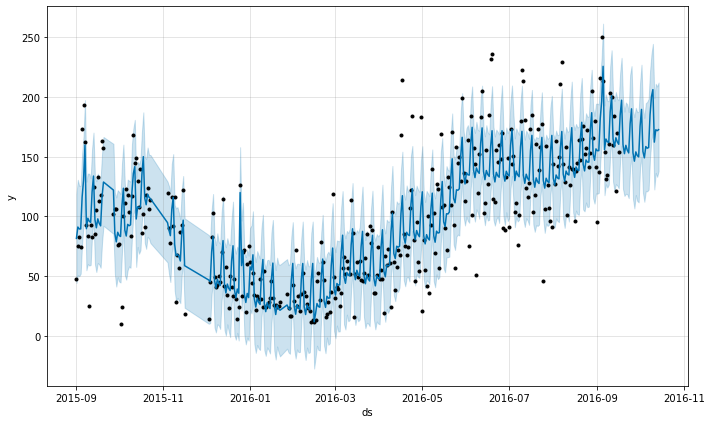

In [21]:
p.plot(forecast);

可视化预测组件，以查看一般趋势、季节性和假期。

请注意`;`？参考这个[GitHub问题](https://github.com/facebook/prophet/issues/503)。

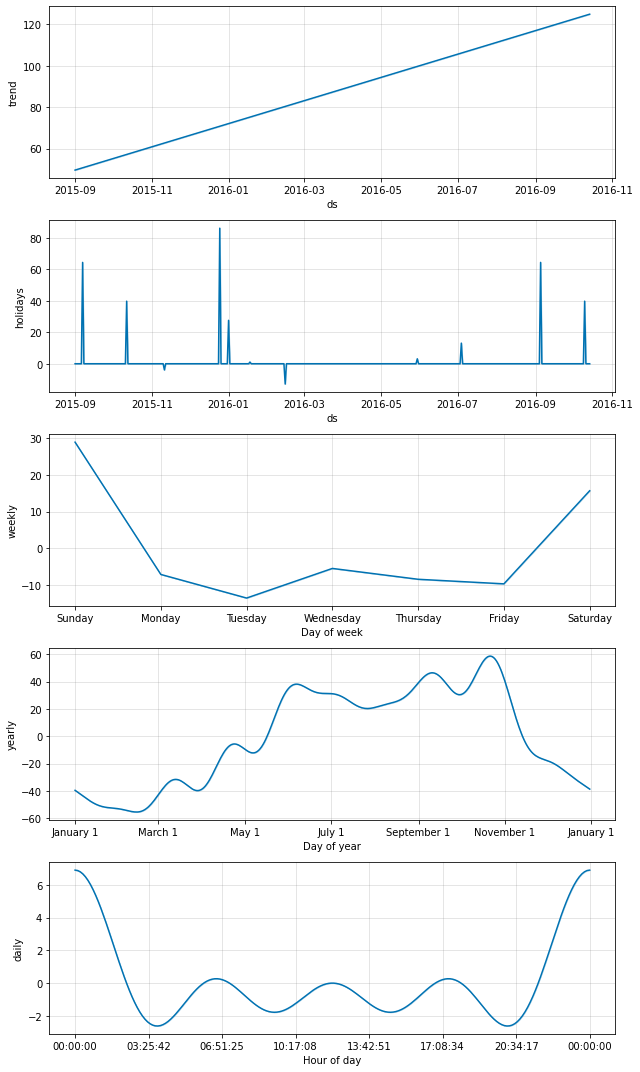

In [22]:
p.plot_components(forecast);

使用Plotly进行交互式时间序列可视化。

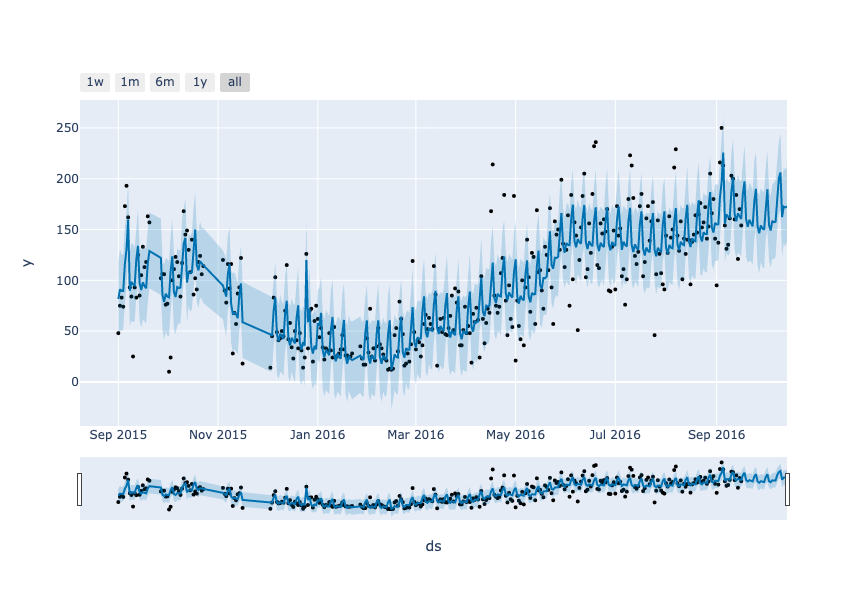

In [23]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(p, forecast)

创建预测模型 - 所有系列... 并行

Prophet 没有输入来指示分开的时间序列。为了拟合所有时间序列并利用现有的计算资源，我们将使用 Python 的 multiprocessing 包。

创建一个函数来拟合一个序列

返回一个包括预测时间跨度在内的整个序列的数据框，包括拟合的预测和置信区间：

In [24]:
def run_prophet(series):
    p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = 2*14)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

在单个系列上测试该功能

In [25]:
test = run_prophet(seriesFrames[5])
test

13:23:59 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower  yhat_upper
0   2015-09-01   94.244867   52.683595  132.255934
1   2015-09-02  102.167976   60.327621  141.749892
2   2015-09-03   98.709119   55.951957  138.638070
3   2015-09-04   97.133015   51.702838  138.474679
4   2015-09-05  121.472544   83.630130  162.353054
..         ...         ...         ...         ...
368 2016-10-10  254.916619  215.902992  295.940533
369 2016-10-11  179.495672  137.200790  222.860573
370 2016-10-12  188.513454  147.700410  227.370381
371 2016-10-13  186.149270  144.447379  225.029042
372 2016-10-14  185.667839  145.947712  226.506083

[373 rows x 4 columns]

设置多进程

In [26]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

查看此笔记本可用的 CPU 数量。我们在设置此笔记本实例时选择了 `n1-standard-4`，因此预计应该看到 4 个：

In [27]:
cpu_count()

4

将所有系列并行运行

三件事：
- 设置一个可以使用所有CPU的池
- 将`run_prophet`函数映射到列表`seriesFrames`中的每个数据框
- 将每个系列的输出存储在一个共同的列表`predictions`中

奖励：
- 使用`tqdm`软件包为所有系列的整个过程呈现进度条

In [28]:
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

  0%|          | 0/12 [00:00<?, ?it/s]13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:03<00:36,  3.31s/it]13:24:15 - cmdstanpy - INFO - Chain [1] start processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:08<00:43,  4.33s/it]13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:20 - cmdstanpy -

### 检查对其中一系列产品的预测

In [29]:
predictions[0]

ds        yhat  yhat_lower  yhat_upper
0  2016-09-01   81.241664   36.092400  125.925598
1  2016-09-02  136.908028   91.187786  178.996251
2  2016-09-03  213.116550  170.277909  256.047835
3  2016-09-04  267.115618  222.886714  308.754095
4  2016-09-05  258.982193  212.201287  299.299529
5  2016-09-06  116.117592   68.210987  161.158773
6  2016-09-07  116.617482   71.827893  158.852517
7  2016-09-08   95.997291   56.613696  138.394034
8  2016-09-09  151.663654  106.237536  195.497598
9  2016-09-10  227.872177  179.193582  271.317976
10 2016-09-11  281.871245  233.292119  325.202497
11 2016-09-12  148.009188  106.879661  192.914010
12 2016-09-13  130.873219   86.354901  175.594328
13 2016-09-14  131.373109   87.413582  177.521372
14 2016-09-15  110.752917   68.412960  149.922081
15 2016-09-16  166.419281  118.953635  210.942353
16 2016-09-17  242.627804  197.914576  284.626936
17 2016-09-18  296.626871  258.074416  340.887071
18 2016-09-19  162.764815  120.127185  205.857061
19 2016-09-20  145.628845  101.352027  187.429556
20 2016-09-21  146.128736   99.535735  190.445215
21 2016-09-22  125.508544   82.479893  169.994037
22 2016-09-23  181.174908  136.638057  227.191826
23 2016-09-24  257.383430  212.306377  298.794159
24 2016-09-25  311.382498  268.056440  357.320591
25 2016-09-26  177.520441  132.255588  221.498873
26 2016-09-27  160.384472  116.923661  207.052257
27 2016-09-28  160.884362  114.255307  206.951565
28 2016-09-29  140.264171   99.712957  185.190321
29 2016-09-30  195.930534  152.702790  239.030061
30 2016-10-01  272.139057  228.899905  318.633132
31 2016-10-02  326.138125  282.655949  374.383486
32 2016-10-03  192.276068  148.554010  236.509837
33 2016-10-04  175.140099  132.114832  217.274032
34 2016-10-05  175.639989  127.966292  218.088694
35 2016-10-06  155.019797  109.431987  196.855016
36 2016-10-07  210.686161  166.795269  252.616170
37 2016-10-08  286.894684  242.236611  331.082932
38 2016-10-09  340.893752  296.427672  383.620349
39 2016-10-10  207.031695  161.515484  248.672550
40 2016-10-11  189.895726  144.874157  237.297534
41 2016-10-12  190.395616  144.665573  235.562522
42 2016-10-13  169.775424  124.038101  212.524209
43 2016-10-14  225.441788  183.221623  273.253306

将结果存储回BigQuery

将每个系列的预测连接起来
创建“start_station_name”列

In [30]:
for i, p in enumerate(predictions):
    p['start_station_name'] = seriesNames[i]
    
output = pd.concat(predictions)
output

ds        yhat  yhat_lower  yhat_upper  \
0   2016-09-01   81.241664   36.092400  125.925598   
1   2016-09-02  136.908028   91.187786  178.996251   
2   2016-09-03  213.116550  170.277909  256.047835   
3   2016-09-04  267.115618  222.886714  308.754095   
4   2016-09-05  258.982193  212.201287  299.299529   
..         ...         ...         ...         ...   
368 2016-10-10  112.312118   86.843729  138.350301   
369 2016-10-11   75.016482   49.139320   99.430144   
370 2016-10-12   78.785608   52.920556  101.298666   
371 2016-10-13   75.861829   51.012642  100.431350   
372 2016-10-14   77.689663   50.197073  102.982535   

                                start_station_name  
0    Central Park North & Adam Clayton Powell Blvd  
1    Central Park North & Adam Clayton Powell Blvd  
2    Central Park North & Adam Clayton Powell Blvd  
3    Central Park North & Adam Clayton Powell Blvd  
4    Central Park North & Adam Clayton Powell Blvd  
..                                             ...  
368                    W 82 St & Central Park West  
369                    W 82 St & Central Park West  
370                    W 82 St & Central Park West  
371                    W 82 St & Central Park West  
372                    W 82 St & Central Park West  

[4559 rows x 5 columns]

将数据框加载到BigQuery使用Pandas GBQ

[Pandas GBQ参考](https://cloud.google.com/bigquery/docs/pandas-gbq-migration#loading_a_pandas_dataframe_to_a_table)

In [31]:
output.to_gbq(f"{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet", f'{PROJECT_ID}', if_exists = 'replace')

100%|██████████| 1/1 [00:00<00:00, 6403.52it/s]


使用BigQuery来转换结果：与源数据结合生成系列数据。

In [33]:
Tjob = bq_runner(
    query = f"""
        CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet` AS
        WITH
            SOURCE AS (
                SELECT *
                FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
            ),
            PROPHET AS (
                SELECT start_station_name, DATE(ds) as date, yhat, yhat_lower, yhat_upper
                FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
            )
        SELECT *
        FROM PROPHET
        LEFT OUTER JOIN SOURCE
        USING (start_station_name, date)
        ORDER by start_station_name, date
    """
)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

1.539

结果

检索测试数据

In [34]:
prophet = bq_runner(
    query = f"""
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    """
).to_dataframe()
prophet

date  num_trips splits  \
0    2016-09-17        269   TEST   
1    2016-09-18        272   TEST   
2    2016-09-19         39   TEST   
3    2016-09-20        120   TEST   
4    2016-09-21        164   TEST   
..          ...        ...    ...   
154  2016-09-26        102   TEST   
155  2016-09-27        105   TEST   
156  2016-09-28         72   TEST   
157  2016-09-29        143   TEST   
158  2016-09-30         42   TEST   

                                start_station_name  predicted_num_trips  
0    Central Park North & Adam Clayton Powell Blvd           242.627804  
1    Central Park North & Adam Clayton Powell Blvd           296.626871  
2    Central Park North & Adam Clayton Powell Blvd           162.764815  
3    Central Park North & Adam Clayton Powell Blvd           145.628845  
4    Central Park North & Adam Clayton Powell Blvd           146.128736  
..                                             ...                  ...  
154                    W 82 St & Central Park West            74.407411  
155                    W 82 St & Central Park West            73.936957  
156                    W 82 St & Central Park West            77.706083  
157                    W 82 St & Central Park West            74.782304  
158                    W 82 St & Central Park West            76.610138  

[159 rows x 5 columns]

### 使用SQL查看自定义指标

用于评估预测效果的一些常见指标包括
- MAPE，即平均绝对百分比误差
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE，即平均绝对误差
    - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- 将MAE除以平均需求以获得类似MAPE的百分比
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE，即均方误差
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE，即均方根误差
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- 将RMSE除以平均需求以获得类似MAPE的百分比
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

明确计算这些指标可能有助于公平比较数据集和模型。本节将使用SQL演示这些计算。

In [35]:
customMetrics = bq_runner(
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    date, 
                    num_trips, 
                    splits, 
                    start_station_name, 
                    yhat as predicted_num_trips
                FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
                WHERE splits = 'TEST'
            ),
            DIFFS AS (
                SELECT 
                    start_station_name, date, 'forecast' as time_series_type,
                    predicted_num_trips as forecast_value,
                    num_trips as actual_value,
                    (num_trips - predicted_num_trips) as diff
                FROM FORECASTS    
            )
        SELECT start_station_name, time_series_type, 
            AVG(ABS(diff)/actual_value) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(actual_value) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE,
            COUNT(diff) as n
        FROM DIFFS
        GROUP BY start_station_name, time_series_type
        ORDER BY start_station_name, time_series_type    
    """
).to_dataframe()
customMetrics

start_station_name time_series_type      MAPE  \
0   Central Park North & Adam Clayton Powell Blvd         forecast  0.783951   
1                          Central Park S & 6 Ave         forecast  0.475182   
2                        Central Park W & W 96 St         forecast  0.463691   
3                    Central Park West & W 100 St         forecast  0.718591   
4                    Central Park West & W 102 St         forecast  0.466372   
5                     Central Park West & W 68 St         forecast  0.551993   
6                     Central Park West & W 72 St         forecast  0.667743   
7                     Central Park West & W 76 St         forecast  0.421664   
8                     Central Park West & W 85 St         forecast  1.049834   
9               Grand Army Plaza & Central Park S         forecast  0.421359   
10                   W 106 St & Central Park West         forecast  0.288137   
11                    W 82 St & Central Park West         forecast  0.364857   

          MAE      pMAE           MSE        RMSE     pRMSE   n  
0   48.905733  0.315085   4056.136186   63.687802  0.410322  14  
1   93.037545  0.285079  13164.384312  114.736151  0.351566  14  
2   25.280066  0.252620    893.017541   29.883399  0.298621  14  
3   14.844421  0.374454    285.879349   16.907967  0.426507  14  
4   11.348224  0.224083    231.763229   15.223772  0.300610  14  
5   49.844157  0.329004   3673.841275   60.612221  0.400081  14  
6   48.044807  0.271558   4562.843432   67.548823  0.381798  13  
7   29.944055  0.273462   1383.035158   37.189181  0.339627  14  
8   48.384986  0.384881   3656.053827   60.465311  0.480974   7  
9   44.519473  0.204723   3890.800322   62.376280  0.286838  13  
10  16.489857  0.246907    343.578853   18.535880  0.277543  14  
11  30.886650  0.334685   1434.108525   37.869625  0.410352  14

整体指标:

In [36]:
customMetricsOverall = bq_runner(
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    date, 
                    num_trips, 
                    splits, 
                    start_station_name, 
                    yhat as predicted_num_trips
                FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
                WHERE splits = 'TEST'
            ),
            DIFFS AS (
                SELECT 
                    start_station_name, date, 'forecast' as time_series_type,
                    predicted_num_trips as forecast_value,
                    num_trips as actual_value,
                    (num_trips - predicted_num_trips) as diff
                FROM FORECASTS    
            )
        SELECT time_series_type, 
            AVG(ABS(diff)/actual_value) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(actual_value) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE,
            COUNT(diff) as n
        FROM DIFFS
        GROUP BY time_series_type
        ORDER BY time_series_type     
    """
).to_dataframe()
customMetricsOverall

time_series_type      MAPE        MAE      pMAE         MSE       RMSE  \
0         forecast  0.534524  37.925537  0.283173  3094.40357  55.627363   

      pRMSE    n  
0  0.415344  159

### 获取预测数据

In [37]:
prophet = bq_runner(
    query = f"""
        SELECT *
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        ORDER by start_station_name, date
    """
).to_dataframe()

检索可视化的关键日期。

In [41]:
keyDates = bq_runner(
    query = f"""
        WITH
            SPLIT AS (
                SELECT splits, min(date) as mindate, max(date) as maxdate
                FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
                GROUP BY splits
            ),
            TRAIN AS (
                SELECT mindate as start_date
                FROM SPLIT
                WHERE splits ='TRAIN'
            ),
            VAL AS (
                SELECT mindate as val_start
                FROM SPLIT
                WHERE splits = 'VALIDATE'
            ),
            TEST AS (
                SELECT mindate as test_start, maxdate as end_date
                FROM SPLIT
                WHERE splits = 'TEST'
            )
        SELECT * EXCEPT(pos) FROM
        (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
        USING (pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
        USING (pos)
    """
).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

### 用预测可视化时间序列

In [42]:
horizondf = prophet[(prophet['splits'].isna())]
horizondf

start_station_name        date        yhat  \
30    Central Park North & Adam Clayton Powell Blvd  2016-10-01  272.139057   
31    Central Park North & Adam Clayton Powell Blvd  2016-10-02  326.138125   
32    Central Park North & Adam Clayton Powell Blvd  2016-10-03  192.276068   
33    Central Park North & Adam Clayton Powell Blvd  2016-10-04  175.140099   
34    Central Park North & Adam Clayton Powell Blvd  2016-10-05  175.639989   
...                                             ...         ...         ...   
4554                    W 82 St & Central Park West  2016-10-10  112.312118   
4555                    W 82 St & Central Park West  2016-10-11   75.016482   
4556                    W 82 St & Central Park West  2016-10-12   78.785608   
4557                    W 82 St & Central Park West  2016-10-13   75.861829   
4558                    W 82 St & Central Park West  2016-10-14   77.689663   

      yhat_lower  yhat_upper  num_trips splits  
30    228.899905  318.633132        NaN   None  
31    282.655949  374.383486        NaN   None  
32    148.554010  236.509837        NaN   None  
33    132.114832  217.274032        NaN   None  
34    127.966292  218.088694        NaN   None  
...          ...         ...        ...    ...  
4554   86.843729  138.350301        NaN   None  
4555   49.139320   99.430144        NaN   None  
4556   52.920556  101.298666        NaN   None  
4557   51.012642  100.431350        NaN   None  
4558   50.197073  102.982535        NaN   None  

[177 rows x 7 columns]

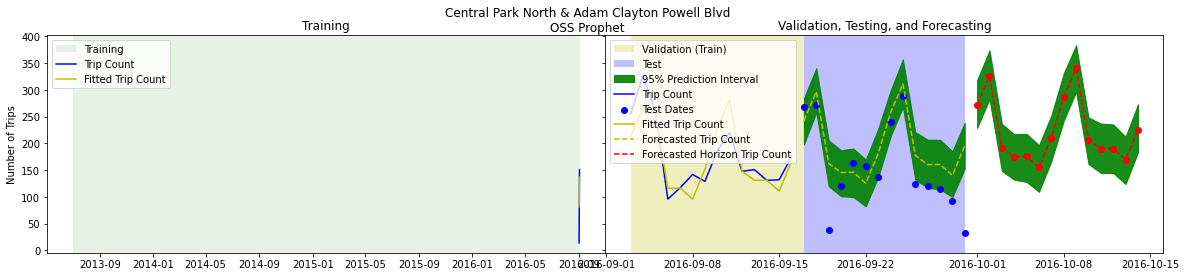

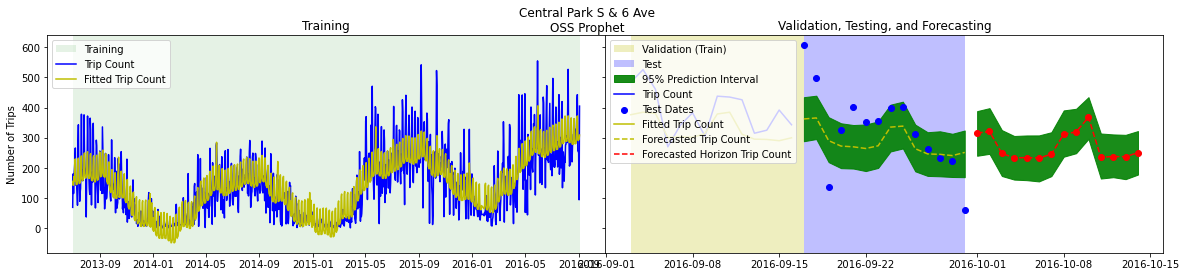

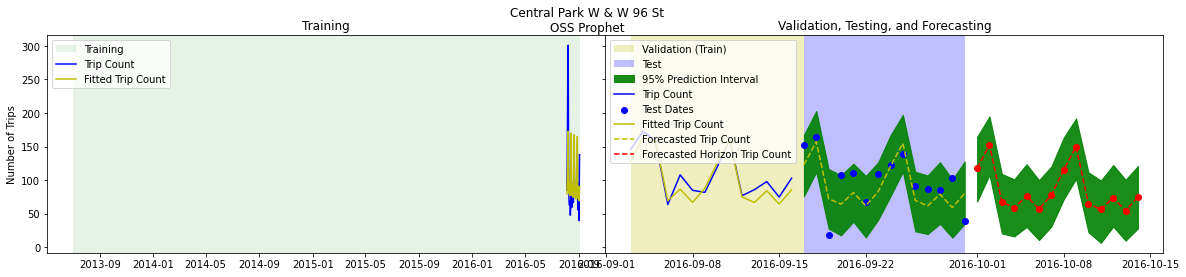

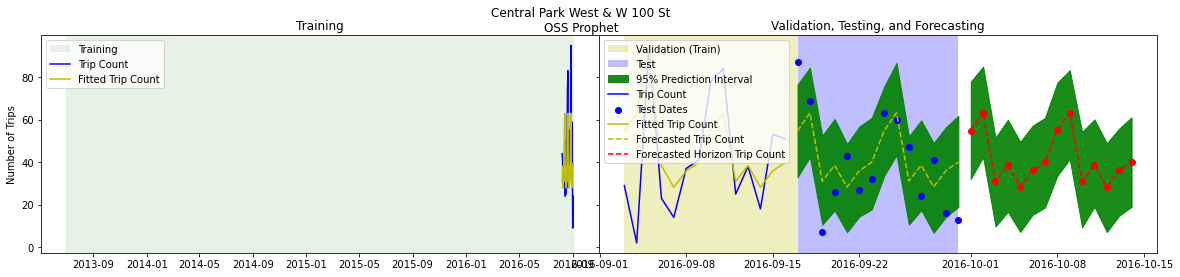

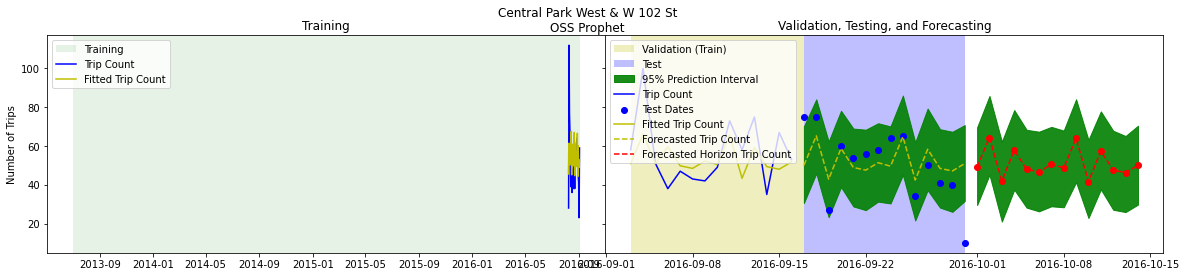

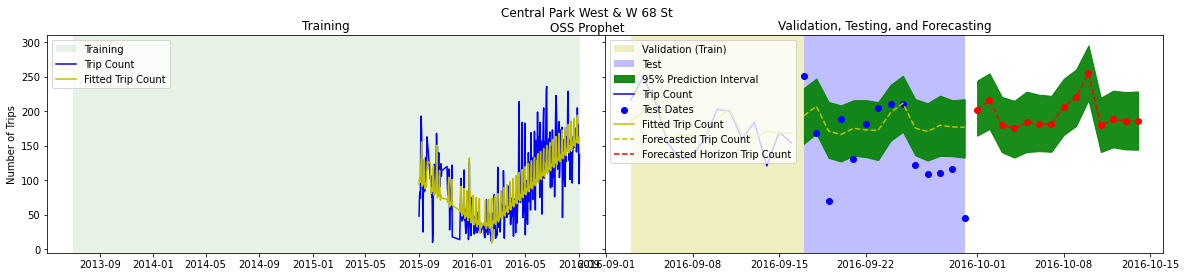

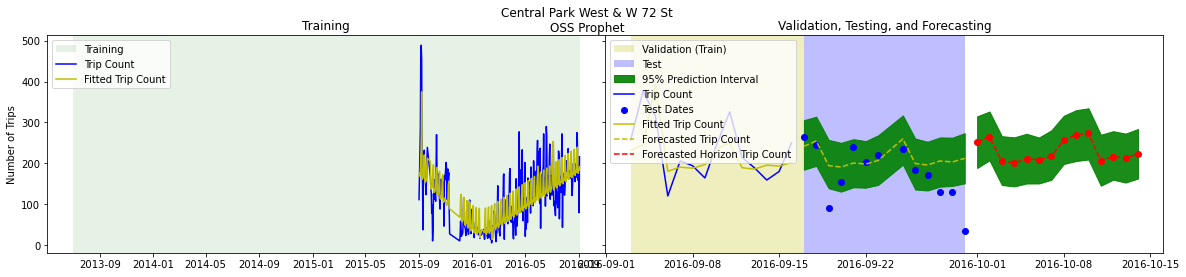

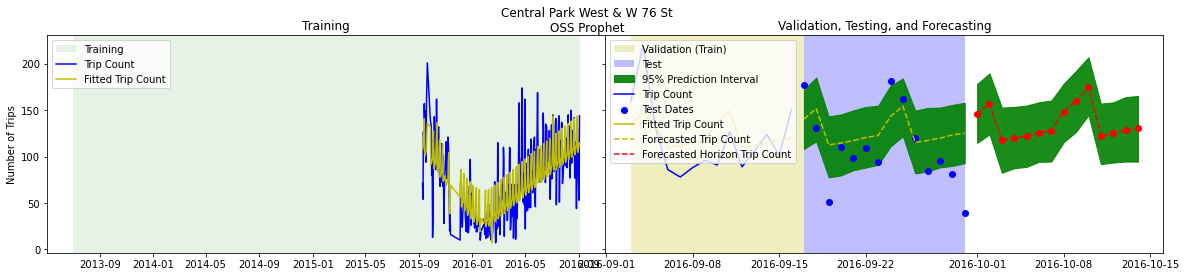

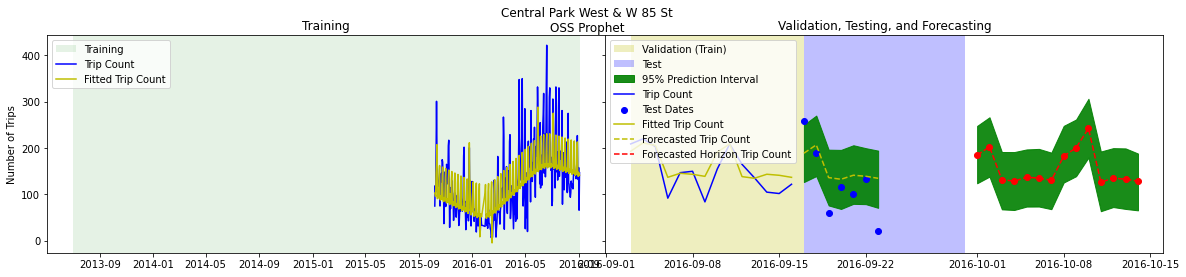

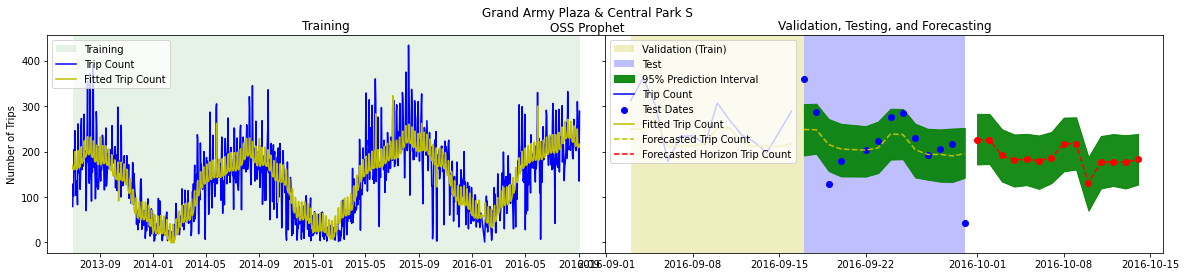

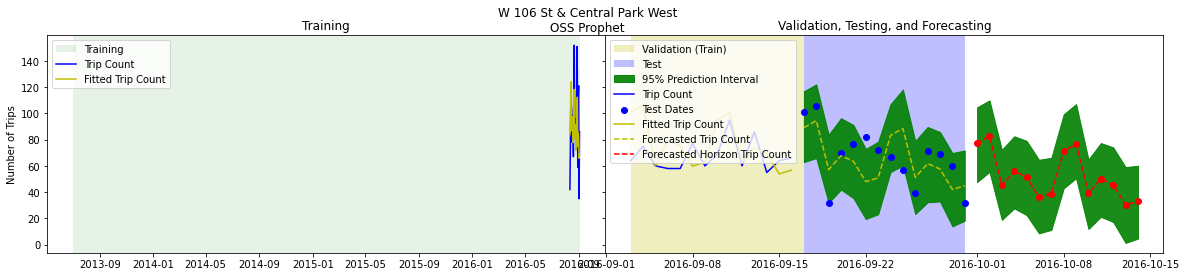

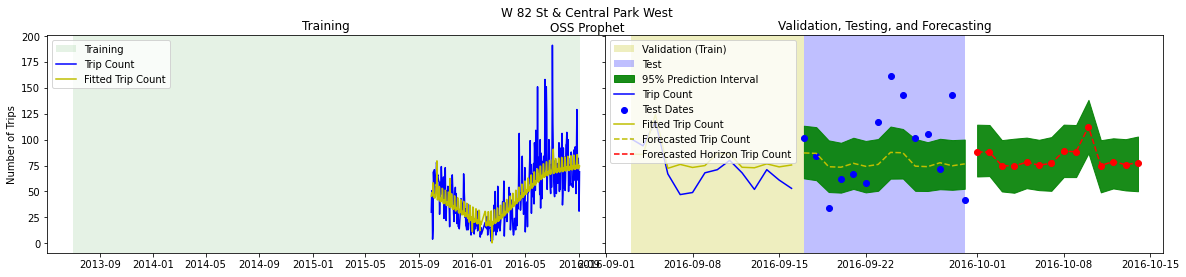

In [44]:
stations = prophet['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TRAIN')]
    valdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'VALIDATE')]
    testdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TEST')]
    horizondf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'].isna()) & (prophet['date'] > keyDates['end_date'][0])]
    #fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(testdf['date'], testdf['yhat_lower'], testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    axes[1].fill_between(horizondf['date'], horizondf['yhat_lower'], horizondf['yhat_upper'], color = 'g', alpha = 0.9)
    
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    axes[1].scatter(horizondf['date'], horizondf['yhat'], color = 'r')
    
    axes[0].plot(traindf['date'], traindf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(valdf['date'], valdf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(testdf['date'], testdf['yhat'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].plot(horizondf['date'], horizondf['yhat'], color = 'r', label = 'Forecasted Horizon Trip Count', linestyle='dashed')
    #axes[1].scatter(testdf['date'], testdf['yhat'], color = 'y')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nOSS Prophet")

    # display result
    plt.show()

删除资源
查看笔记本"99 - 清理"